In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import warnings
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import kstest_normal

import torch
import gpytorch
from gpytorch.kernels import Kernel
from gpytorch.functions import RBFCovariance
from gpytorch.settings import trace_mode
from gpytorch.utils.warnings import GPInputWarning

In [5]:
with open("rNoOuputNoReg.json", "r") as final:
    rNoOuputNoReg=json.load(final)
with open("rOuputNoReg.json", "r") as final:
    rOuputNoReg=json.load(final)
with open("rNoOuputReg2.json", "r") as final:
    rNoOuputReg2=json.load(final)
with open("rOuputReg2.json", "r") as final:
    rOuputReg2=json.load(final)
with open("rNoOuputReg1.json", "r") as final:
    rNoOuputReg1=json.load(final)
with open("rOuputReg1.json", "r") as final:
    rOuputReg1=json.load(final)

In [6]:
def getPredIdx(data):
    idx=[]
    for i in data['respVar']:
        if len(i['index'])>0:
            idx.append(i['index'])
    return idx

def minLnonRelevant(data):
    m=0
    idx=0
    for i in data['nonpredIdx'][0]:
        if data['lengthscales'][i]>m:
            m=data['lengthscales'][i]
            idx=i
    return idx

def getMinScoreLnonPred(data):
    scores=(1/np.array(data['lengthscales'])**2)/np.sum(1/np.array(data['lengthscales'])**2).item()
    return scores[minLnonRelevant(data)]

def getMinVarResponse(data):
    s=0
    minR=100000
    minidx=0
    for i in getPredIdx(data):
        s=s+data['respVar'][i[0]]['respVar'][0]
        if data['respVar'][i[0]]['respVar'][0]<minR:
            minR=data['respVar'][i[0]]['respVar'][0]
            minidx=i[0]
    scores=(1/np.array(data['lengthscales'])**2)/np.sum(1/np.array(data['lengthscales'])**2).item()

    return [minidx,1-(minR/s),scores[minidx]]

def getLossSample(data, threshold, w):
    l=(getMinScoreLnonPred(data)-threshold)**2 + w*getMinVarResponse(data)[1]*(getMinVarResponse(data)[2]-threshold)**2
    return l

def getLossDataset(data, threshold, w):
    s=0
    for i in data:
        s=s+getLossSample(i, threshold, w)
    return s/len(data)
    

## Optimizing global threshold (critical score value)

In [7]:
def globalThreshold(data,min_,max_,n1,n2,weight):
    bestSc=[100000,100000,100000,100000,100000]
    d={}
    for i in range(n1):
        t=np.random.uniform(min_,max_,1).item()
        s=getLossDataset(data,t,weight)
        if s<bestSc[0]:
            bestSc[-1]=s
            d[str(s)]=t
            bestSc.sort()
        else:
            continue
    ts=[]
    for i in bestSc:
        ts.append(d[str(i)])
    m=np.array(ts).mean().item()
    ts.sort()
    diff=ts[-1]-m
    bestS=10000
    bestT=m
    for i in range(n2):
        t=np.random.normal(loc=m, scale=diff, size=1).item()
        s=getLossDataset(data,t,weight)
        if s<bestS:
            bestS=s
            bestT=t
    return t, bestS

def detScore(data, threshold):
    r=[]
    for i in data:
        scores=[]
        sum_=np.array(i['lengthscales']).sum().item()
        for j in i['lengthscales']:
            scores.append(j/sum_)
            thresh=np.array(scores)-threshold
        flag=True
        for j in i['nonpredIdx'][0]:
            if thresh[j]>0:
                for k in getPredIdx(i):
                    if thresh[k]<0:
                        continue
                    else:
                        flag=False
            else:
                flag=False
        if flag==True:
            r.append(1)
        else:
            r.append(0)

    return np.array(r).sum().item()/len(r),r

def thresh(data,min_,max_,n1,n2):
    bestSc=[0,0,0]
    d={}
    for i in range(n1):
        t=np.random.uniform(min_,max_,1).item()
        s=detScore(data,t)[0]
        if s>bestSc[0]:
            bestSc[0]=s
            d[str(s)]=t
            bestSc.sort()
        else:
            continue
    ts=[]
    for i in bestSc:
        ts.append(d[str(i)])
    m=np.array(ts).mean().item()
    diff=np.array(ts)-m
    bestS=0
    bestT=m
    for i in range(n2):
        t=np.random.normal(loc=m, scale=0.02, size=1).item()
        s,r=detScore(data,t)
        if s>bestS:
            bestS=s
            bestT=t
            rr=r
    return t, bestS, rr

In [8]:
globalThreshold(rNoOuputNoReg,0.09,0.25,10000,5000,0.5)

(0.11528667805386682, 0.005216307402765807)

In [9]:
thresh(rNoOuputNoReg,0.09,0.25,10000,5000)[:2]

(0.11162174508076944, 0.05)

In [10]:
globalThreshold(rOuputNoReg,0.09,0.25,10000,5000,0.5)

(0.11890482451797775, 0.004970448510967728)

In [11]:
thresh(rOuputNoReg,0.09,0.25,10000,5000)[:2]

(0.13603636023681456, 0.04)

In [12]:
globalThreshold(rNoOuputReg2,0.09,0.25,10000,5000,0.5)

(0.12215999896920096, 0.002445815990790676)

In [13]:
thresh(rNoOuputReg2,0.09,0.25,10000,5000)[:2]

(0.10380084634945536, 0.04)

In [14]:
globalThreshold(rOuputReg2,0.09,0.25,10000,5000,0.5)

(0.12283742383574983, 0.00223178706761743)

In [15]:
thresh(rOuputReg2,0.09,0.25,10000,5000)[:2]

(0.07835773656409532, 0.04)

In [16]:
globalThreshold(rNoOuputReg1,0.09,0.25,10000,5000,0.5)

(0.11814757340467295, 0.004672461924821961)

In [17]:
thresh(rNoOuputReg1,0.09,0.25,10000,5000)[:2]

(0.10996560769203237, 0.055)

In [18]:
globalThreshold(rOuputReg1,0.09,0.25,10000,5000,0.5)

(0.12391092147194299, 0.001941774425739474)

In [19]:
thresh(rOuputReg1,0.09,0.25,10000,5000)[:2]

(0.14252813236868292, 0.035)

## In sample optim threshold

Method1

In [20]:
def findOptim1(data):
    rt=[]
    for i in data:
        scores=(1/np.array(i['lengthscales'])**2)/np.sum(1/np.array(i['lengthscales'])**2).item()

        nps=0
        for j in i['nonpredIdx'][0]:
            if scores[j]>nps:
                nps=scores[j]
        ps=1000
        for k in getPredIdx(i):
            if scores[k[0]]<ps:
                ps=scores[k[0]]
                wr=i['respVar'][k[0]]['respVar'][0]
        
        rt.append((1-wr)*ps+wr*nps)
    return rt        

In [21]:
np.array(findOptim1(rNoOuputNoReg)).std()

0.04314147520274397

In [22]:
np.array(findOptim1(rOuputNoReg)).std()

0.04114052150165013

In [23]:
np.array(findOptim1(rNoOuputReg2)).std()

0.03454485352502194

In [24]:
np.array(findOptim1(rOuputReg2)).std()

0.033824451374570776

In [25]:
np.array(findOptim1(rNoOuputReg1)).std()

0.03924588426060454

In [26]:
np.array(findOptim1(rOuputReg1)).std()

0.03387058893222707

Method2

In [27]:
def findOptimSample(data, w):
    scores=(1/np.array(data['lengthscales'])**2)/np.sum(1/np.array(data['lengthscales'])**2).item()
    nps=0
    for j in data['nonpredIdx'][0]:
        if scores[j]>nps:
            nps=scores[j]
    ps=1000
    s=0
    for k in getPredIdx(data):
        s=s+data['respVar'][k[0]]['respVar'][0]
        if scores[k[0]]<ps:
            ps=scores[k[0]]
            wr=data['respVar'][k[0]]['respVar'][0]
    wr=wr/s
    return (nps+w*wr*ps)/(1+w*wr)

def findAllOptimSample(data,w):
    r=[]
    for i in data:
        r.append(findOptimSample(i,w))
    return r


In [28]:
print(np.array(findAllOptimSample(rNoOuputNoReg,0.7)).mean())
print(np.array(findAllOptimSample(rNoOuputNoReg,0.7)).std())

0.1116010157443317
0.04194496922811371


In [29]:
print(np.array(findAllOptimSample(rOuputNoReg,0.7)).mean())
print(np.array(findAllOptimSample(rOuputNoReg,0.7)).std())

0.11524262587946359
0.041651049795474036


In [30]:
print(np.array(findAllOptimSample(rNoOuputReg2,0.7)).mean())
print(np.array(findAllOptimSample(rNoOuputReg2,0.7)).std())

0.12177425496976443
0.03483311474845642


In [31]:
print(np.array(findAllOptimSample(rOuputReg2,0.7)).mean())
print(np.array(findAllOptimSample(rOuputReg2,0.7)).std())

0.12237842996329171
0.03422758233249883


In [32]:
print(np.array(findAllOptimSample(rNoOuputReg1,0.7)).mean())
print(np.array(findAllOptimSample(rNoOuputReg1,0.7)).std())

0.11407332233334724
0.03918618858467659


In [33]:
print(np.array(findAllOptimSample(rOuputReg1,0.7)).mean())
print(np.array(findAllOptimSample(rOuputReg1,0.7)).std())

0.12298016290983405
0.03399286472000271


## Datasets

In [45]:
def makeDatasets(data,w):
    df=pd.DataFrame(columns=['WeightedNonLinear','VarWeightedNonLinear','WeightedCovs','VarWeightedCovs', 'RatioPred','Nfeatures','MeanCovs','VarCov','VarY','loss','binaryScore', 'threshold'])
    df['threshold']=findAllOptimSample(data,w)
    df['binaryScore']=0 #thresh(data,0.05,0.25,10000,5000)[-1]
    df['WeightedNonLinear']=0
    df['VarWeightedNonLinear']=0
    df['WeightedCovs']=0
    df['VarWeightedCovs']=0
    df['RatioPred']=0
    df['Nfeatures']=0
    df['MeanCovs']=0
    df['VarCov']=0
    df['VarY']=0
    df['loss']=0
    for i in range(len(data)):
        df.iloc[i,5]=data[i]['nk'][0]
        df.iloc[i,4]=len(data[i]['nonpredIdx'])/data[i]['nk'][0]
        df.iloc[i,-4]=data[i]['sigmay'][0]
        df.iloc[i,-3]=data[i]['ExactMarginalLogLikelihood'][0]
        covs=[]
        for j in range(1,data[i]['nk'][0]):
            for k in range(j):
                covs.append(np.array(data[i]['covs'])[j,k])
        df.iloc[i,6]=np.array(covs).mean().item()
        df.iloc[i,7]=np.array(covs).std().item()
        weightedR=[]
        for j in getPredIdx(data[i]):
            weightedR.append([data[i]['respVar'][j[0]]['respVar'][0], data[i]['respVar'][j[0]]['R^2'][0]])
        df.iloc[i,0]=((np.array(weightedR)[:,0]/np.array(weightedR)[:,0].sum())*np.array(weightedR)[:,1]).mean().item()
        df.iloc[i,1]=((np.array(weightedR)[:,0]/np.array(weightedR)[:,0].sum())*np.array(weightedR)[:,1]).std().item()
        weightedCov=[]
        for j in data[i]['nonpredIdx'][0]:
            for k in getPredIdx(data[i]):
                weightedCov.append([data[i]['respVar'][k[0]]['respVar'][0], np.array(data[i]['covs'])[j,k[0]]])
        df.iloc[i,2]=((np.array(weightedCov)[:,0]/np.array(weightedCov)[:,0].sum())*np.array(weightedCov)[:,1]).mean().item()
        df.iloc[i,3]=((np.array(weightedCov)[:,0]/np.array(weightedCov)[:,0].sum())*np.array(weightedCov)[:,1]).std().item()
    return df


In [46]:
df_rNoOuputNoReg=makeDatasets(rNoOuputNoReg,0.7)
df_rOuputNoReg=makeDatasets(rOuputNoReg,0.7)
df_rOuputReg1=makeDatasets(rOuputReg1,0.7)
df_rNoOuputReg1=makeDatasets(rNoOuputReg1,0.7)
df_rOuputReg2=makeDatasets(rOuputReg2,0.7)
df_rNoOuputReg2=makeDatasets(rNoOuputReg2,0.7)

In [47]:
df_rOuputReg1

,WeightedNonLinear,VarWeightedNonLinear,WeightedCovs,VarWeightedCovs,RatioPred,Nfeatures,MeanCovs,VarCov,VarY,loss,binaryScore,threshold
0,0.248108,0.120311,0.000039,0.006077,0.125000,8,-0.022374,0.087832,1.697671,1.023251,0,0.124722
1,0.133315,0.062674,0.000834,0.015370,0.166667,6,0.027179,0.076600,2.240563,1.330029,0,0.165299
2,0.086928,0.069312,-0.000498,0.002709,0.090909,11,-0.010238,0.074096,1.835249,1.227345,0,0.077056
3,0.247433,0.186838,-0.008617,0.015945,0.166667,6,0.025795,0.159353,0.980399,1.093767,0,0.166661
4,0.153450,0.110461,-0.001176,0.008329,0.111111,9,0.003699,0.141835,1.925212,1.191894,0,0.105455
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.099553,0.036755,-0.001340,0.004757,0.090909,11,-0.021967,0.138497,3.610033,1.970599,0,0.085269
196,1.000000,0.000000,-0.010084,0.016686,0.166667,6,-0.003771,0.085923,0.699718,0.986028,0,0.166962
197,0.082143,0.048347,0.000577,0.003551,0.090909,11,-0.002052,0.097691,3.476361,2.415709,0,0.089241
198,0.078918,0.034348,0.002917,0.006976,0.125000,8,0.026748,0.069132,0.758036,-0.133109,0,0.119613


<AxesSubplot: xlabel='threshold', ylabel='Count'>

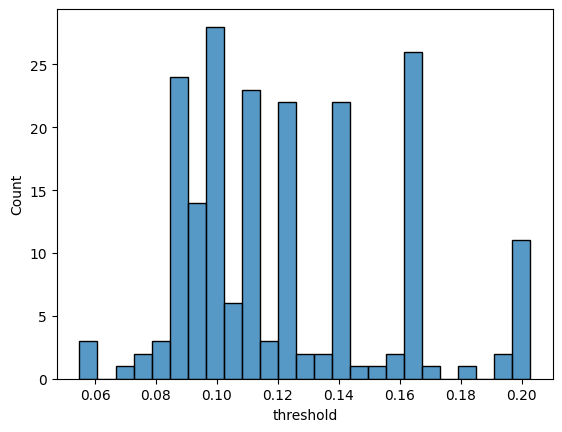

In [49]:
sns.histplot(df_rOuputReg1['threshold'], bins=25)

In [50]:
import statsmodels.api as sm
y = df_rOuputReg1['threshold']
x=df_rOuputReg1[['WeightedNonLinear','VarWeightedNonLinear','WeightedCovs','VarWeightedCovs', 'RatioPred','Nfeatures','MeanCovs','VarCov','VarY','loss']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              threshold   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     337.7
Date:                Mon, 20 Feb 2023   Prob (F-statistic):          8.21e-115
Time:                        12:32:50   Log-Likelihood:                 686.29
No. Observations:                 200   AIC:                            -1351.
Df Residuals:                     189   BIC:                            -1314.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0076 